In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="dark")

In [2]:
data = pd.read_csv('train.csv')
df = data.copy()
data_r = pd.read_csv('Riders.csv')
df_r = data_r.copy()
df_merged = pd.merge(df, df_r, how='inner', on='Rider Id')

# Exploratory Data Analysis

In [3]:
df_merged.shape

(21201, 33)

In [4]:
df_merged['Speed km/h'] = (df_merged['Time from Pickup to Arrival']/3600 * df_merged['Distance (KM)'])

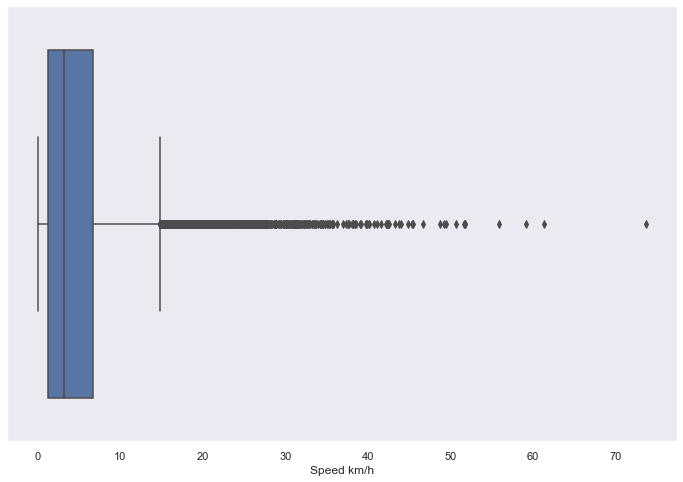

In [5]:
plt.figure(figsize = (12,8))
sns.boxplot(x = 'Speed km/h', data = df_merged)
plt.show()

In [6]:
df_merged = df_merged[(df_merged['Speed km/h'] < 30)]

In [7]:
df_merged.shape[0] - (df_merged['Speed km/h'] < 1).sum()

16890

In [8]:
(df_merged['Speed km/h'] < 1).sum()

4190

10 000 (près de la moitié du df) observations ont une vitesse < 3 KM/h, est ce normal ? (4190 ont des vitesses < 1 KM/h ce qui semble impossible pour un vélo)

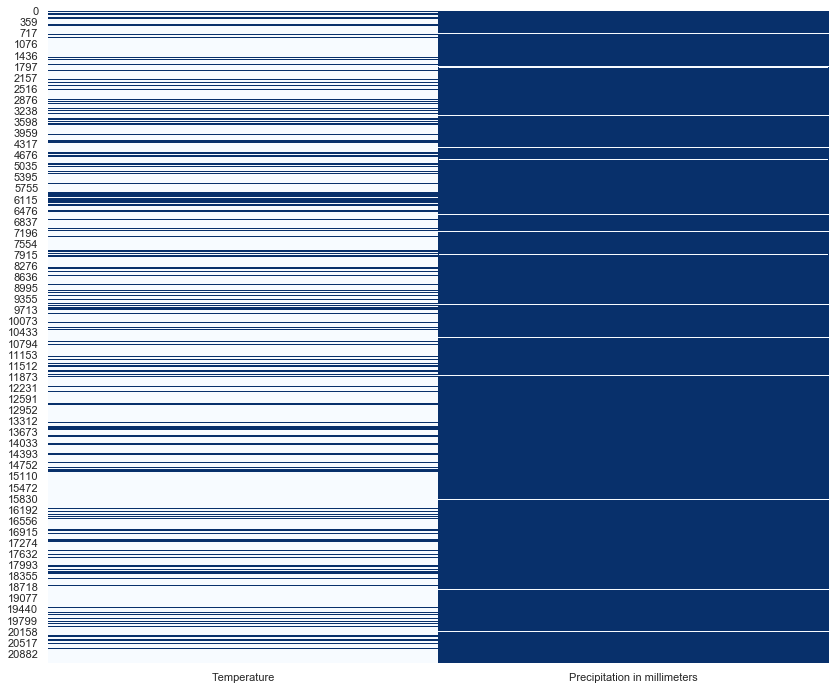

In [9]:
plt.figure(figsize = (14,12))
sns.heatmap(df_merged[['Temperature','Precipitation in millimeters']].isna(), cmap = 'Blues', cbar = False)

La majorité des données sur les precipitations sont vides. C'est moins flagrant pour la temperature.

In [10]:
((df_merged['Temperature'].isna().sum())/(df_merged['Temperature'].shape[0])) * 100

20.630929791271345

## Analyse de fond

### Visualisation de la target

In [11]:
df_merged['Time from Pickup to Arrival'].describe()

count    21080.000000
mean      1539.501708
std        960.289205
min          1.000000
25%        879.000000
50%       1363.000000
75%       2025.000000
max       7714.000000
Name: Time from Pickup to Arrival, dtype: float64

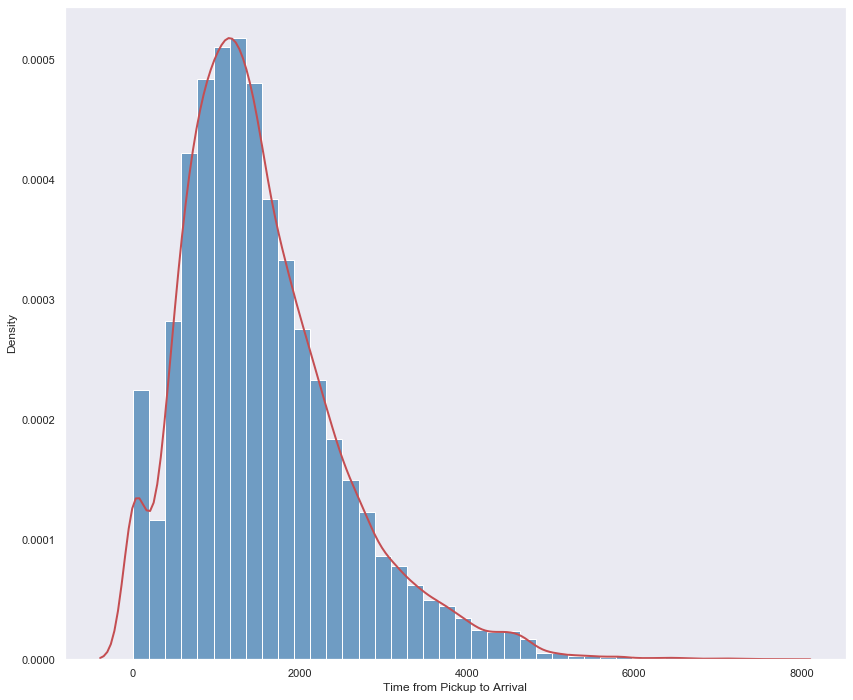

In [12]:
plt.figure(figsize = (14,12))
sns.histplot(x=df_merged['Time from Pickup to Arrival'], color='steelblue', bins = 40, stat='density')
sns.kdeplot(x=df_merged['Time from Pickup to Arrival'], color='r', linewidth=2)
plt.xlabel('Time from Pickup to Arrival')
plt.ylabel('Density')
plt.show()

Séparation en variables numériques et catégorielles

In [13]:
numerical_col = df_merged.select_dtypes(include=['int64','float']).columns

categorical_col = df_merged.select_dtypes(exclude=['int64','float']).columns

time_col = ['Pickup - Time', 'Arrival at Pickup - Time', 'Placement - Time',
        'Confirmation - Time', 'Arrival at Destination - Time']
categorical_col = categorical_col.drop(['Order No','User Id', 'Rider Id'])
categorical_col = categorical_col.drop(time_col)
numerical_col = numerical_col.tolist()
categorical_col = categorical_col.tolist()

colToswitch = ['Platform Type',
                'Placement - Weekday (Mo = 1)',
                'Arrival at Pickup - Weekday (Mo = 1)',
               'Confirmation - Weekday (Mo = 1)',
               'Pickup - Weekday (Mo = 1)',
               'Arrival at Destination - Weekday (Mo = 1)',
               ]
categorical_col.extend(colToswitch)
for col in colToswitch:
    numerical_col.remove(col)
numerical_col.remove('Time from Pickup to Arrival')

#### Visualisation et analyse des variables numériques

Pour les variables numériques :
    <ul>
    <li> Toutes les variables "Day of Month" sont identiquements distribuées, il semble y avoir des pics le weekend </li>
    <li> Age à subi une transformation numérique </li>
    <li> Toutes les notes sont comprises entre 12 et 16 et certaines sont = 0 (erreur ?) </li>
    <li> La grande majoritée des distances de livraison est entre 0 et 20 km </li>
    <li> Les températures sont entre 0 et 30 degrés </li>
    </ul>

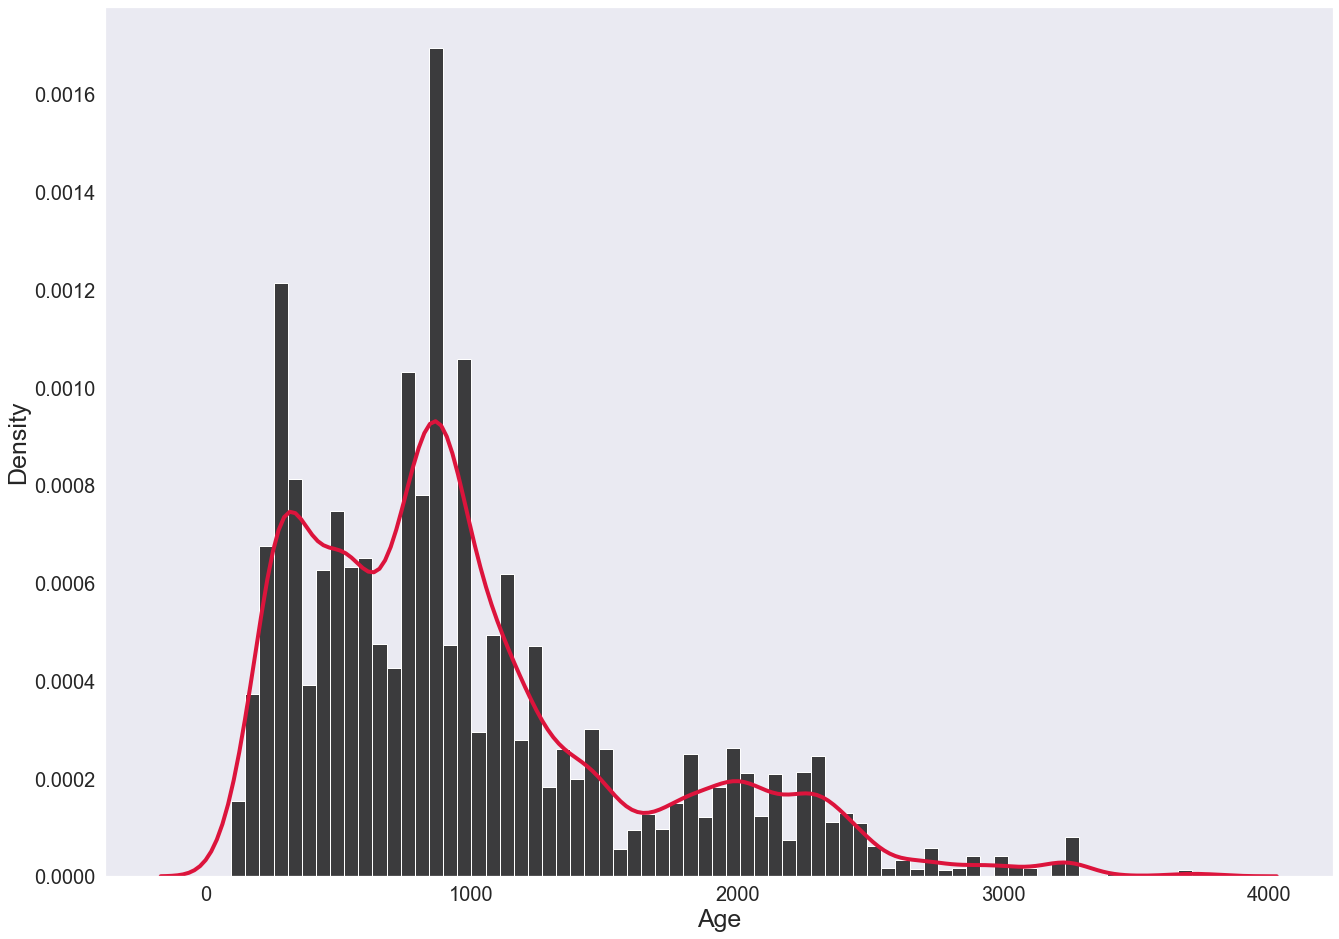

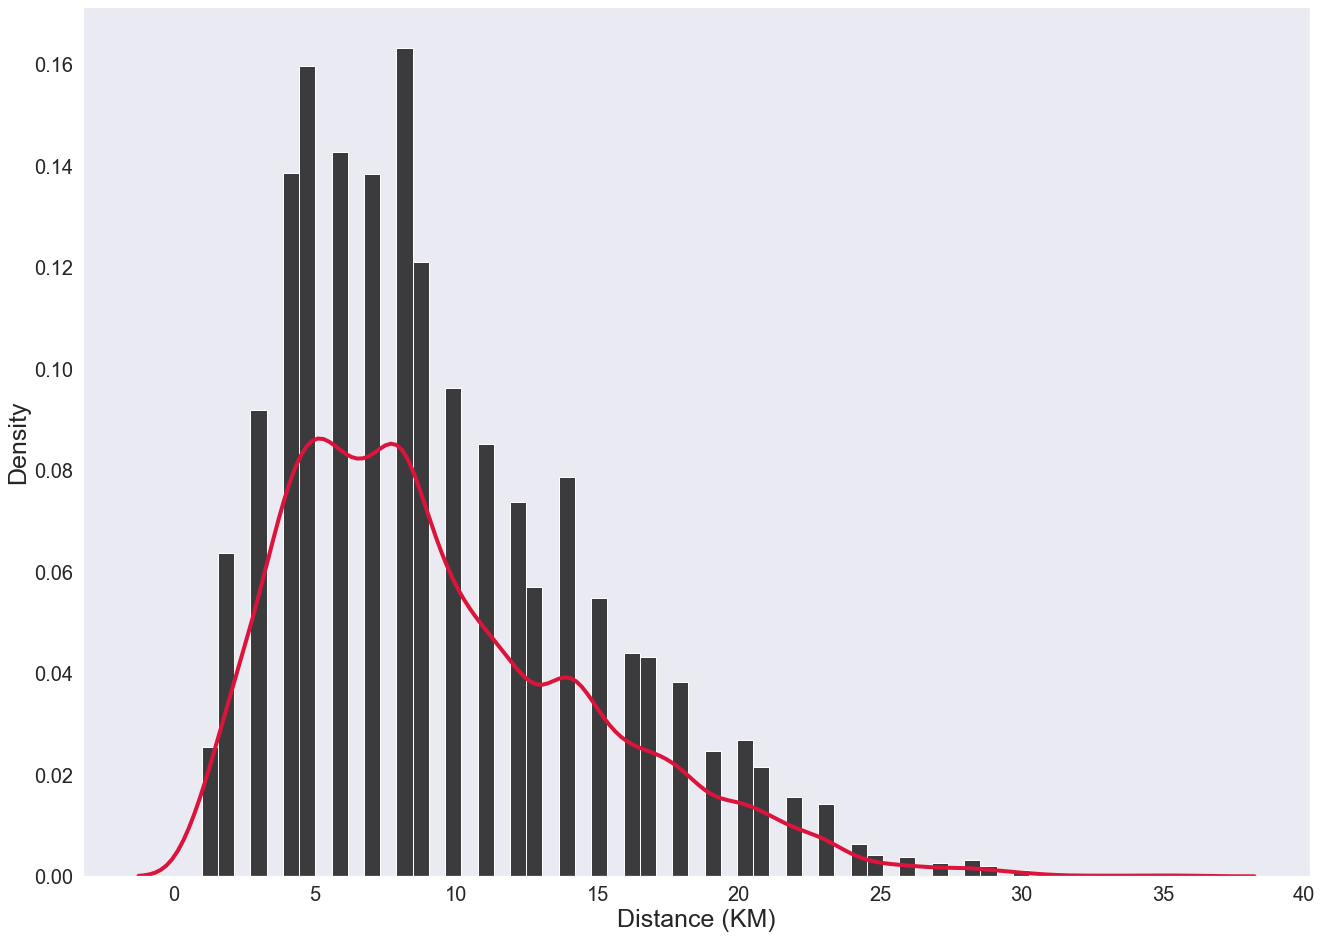

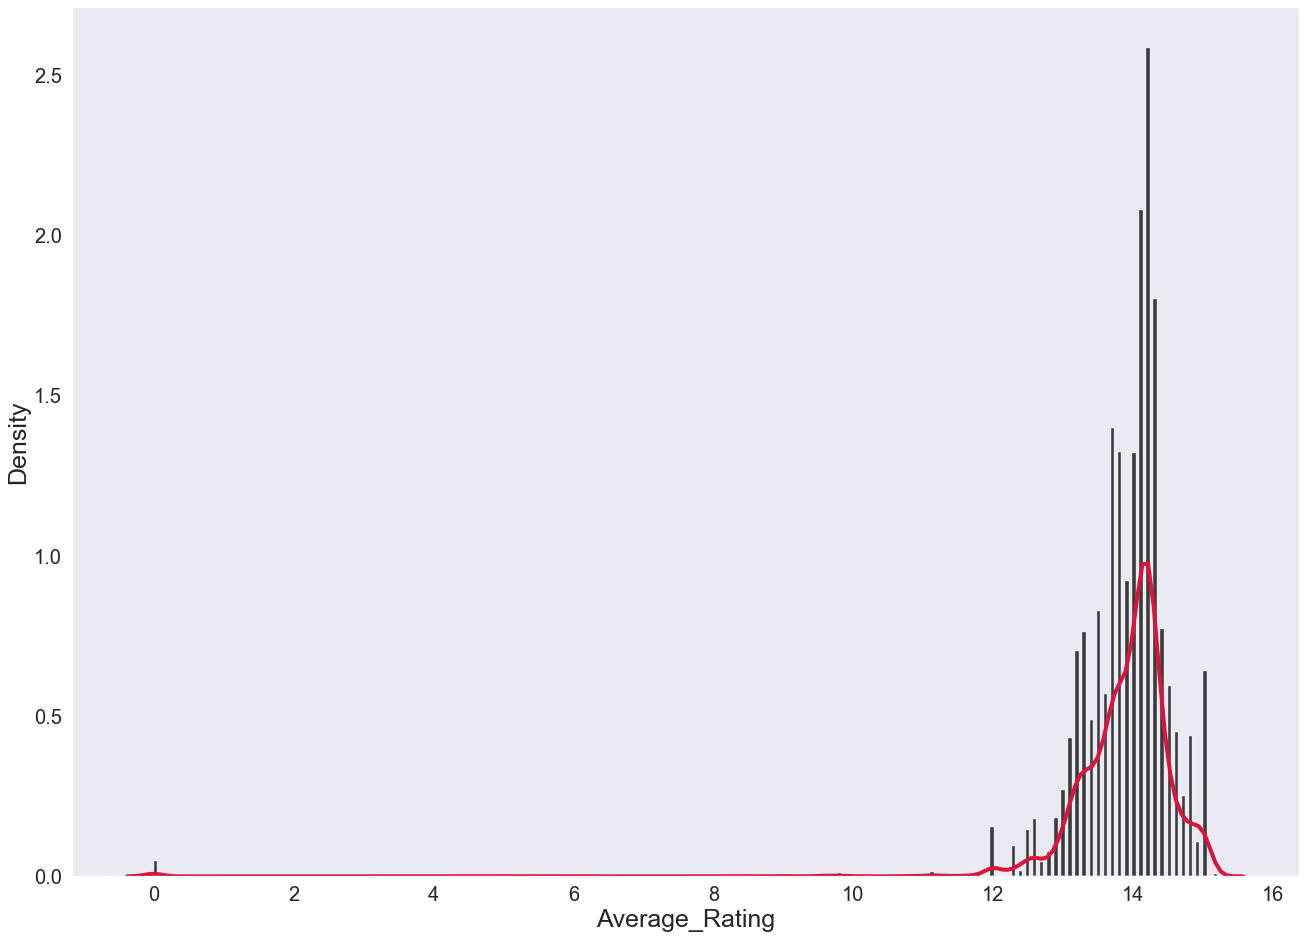

In [14]:
for colonne in ['Age', 'Distance (KM)', 'Average_Rating']:
    plt.figure(figsize = (22,16))
    sns.histplot(x=df_merged[colonne], color='black', stat='density')
    sns.kdeplot(x=df_merged[colonne], color='crimson', linewidth=4)
    plt.xlabel(colonne, fontsize = 25)
    plt.ylabel('Density', fontsize = 25)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.show()

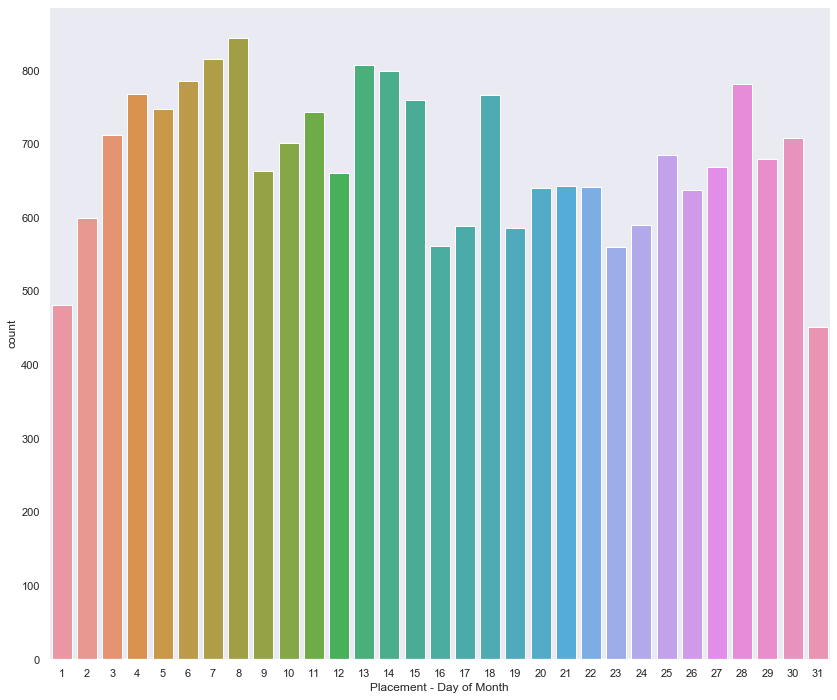

In [15]:
plt.figure(figsize = (14,12))
sns.countplot(x = 'Placement - Day of Month', data=df_merged)
plt.show()

#### Visualisation et analyse des variables qualitatives

In [16]:
def transfo_jour(x):
    if x == 1:
        x = str('Monday')
    elif x == 2:
        x = str('Tuesday')
    elif x == 3:
        x = str('Wednesday')
    elif x == 4:
        x = str('Thursday')
    elif x == 5:
        x = str('Friday')
    elif x == 6:
        x = str('Saturday')
    else:
        x = str('Sunday')
    return x

In [17]:
import re
for col in categorical_col:
    if(re.search('Weekday',col)) != None:
       df_merged[col] = df_merged[col].apply(transfo_jour)

In [18]:
for col in df[categorical_col]:
    print(f'{col :-<50} {df_merged[col].unique()}')

Vehicle Type-------------------------------------- ['Bike']
Personal or Business------------------------------ ['Business' 'Personal']
Platform Type------------------------------------- [3 2 1 4]
Placement - Weekday (Mo = 1)---------------------- ['Friday' 'Tuesday' 'Wednesday' 'Monday' 'Thursday' 'Saturday' 'Sunday']
Arrival at Pickup - Weekday (Mo = 1)-------------- ['Friday' 'Tuesday' 'Wednesday' 'Monday' 'Thursday' 'Saturday' 'Sunday']
Confirmation - Weekday (Mo = 1)------------------- ['Friday' 'Tuesday' 'Wednesday' 'Monday' 'Thursday' 'Saturday' 'Sunday']
Pickup - Weekday (Mo = 1)------------------------- ['Friday' 'Tuesday' 'Wednesday' 'Monday' 'Thursday' 'Saturday' 'Sunday']
Arrival at Destination - Weekday (Mo = 1)--------- ['Friday' 'Tuesday' 'Wednesday' 'Monday' 'Thursday' 'Saturday' 'Sunday']


Pour les variables Quantitatives :
    <ul>
    <li> La variable Vehicle Type est inutile car ne comprend qu'une classe </li>
    <li> Il y'a beaucoup plus de clients Buisness que Personal </li>
    <li> Toutes les variables Weekday sont equidistribuées et il semble y'avoir moins de commande le weekend (?)</li>
    <li> La 3e plateforme est la plus utilisée </li>
    </ul>

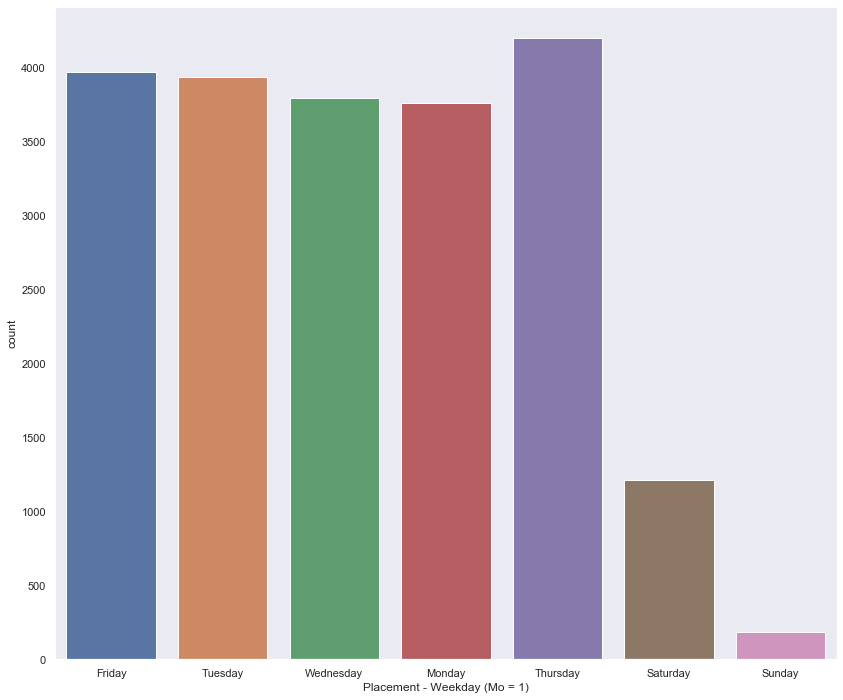

In [19]:
plt.figure(figsize = (14,12))
sns.countplot(x = 'Placement - Weekday (Mo = 1)', data=df_merged)
plt.show()

#### Visualisation et analyse des variables de temps

In [20]:
def time_processing(x):
    if isinstance(x, int):
        return x
    else:
        if(x[-2:] == 'AM'):
            varadd = 0
        else:
            varadd = 12
        h, m, s = x[:-3].split(':')
        h = int(h)+varadd
        x = h
        return x

In [21]:
df_merged = df_merged.copy()
for col in time_col:
    df_merged[col] = df_merged[col].apply(time_processing)

La distribution des variables de temps est sensiblement la même

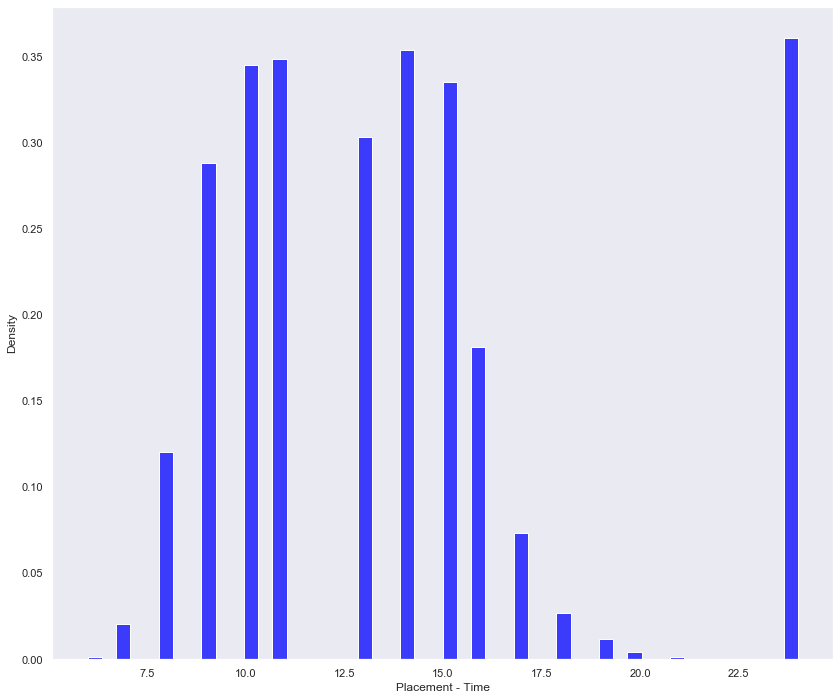

In [22]:
plt.figure(figsize = (14,12))
sns.histplot(x=df_merged['Placement - Time'], color='blue', stat='density')
plt.show()

On peut créer des catégories comme ceci

In [23]:
time_cat = list()
for index in range(df_merged['Placement - Time'].shape[0]):
    if df_merged['Placement - Time'].iloc[index] <= 11:
        time_cat.append("Matin")
    elif df_merged['Placement - Time'].iloc[index] > 11 and df_merged['Placement - Time'].iloc[index] < 17:
        time_cat.append("Apm")
    elif df_merged['Placement - Time'].iloc[index] >= 17 and df_merged['Placement - Time'].iloc[index] <= 22:
        time_cat.append("Soiree")
    elif df_merged['Placement - Time'].iloc[index] > 22:
        time_cat.append("Nuit")

In [24]:
df_merged['Time cat'] = time_cat

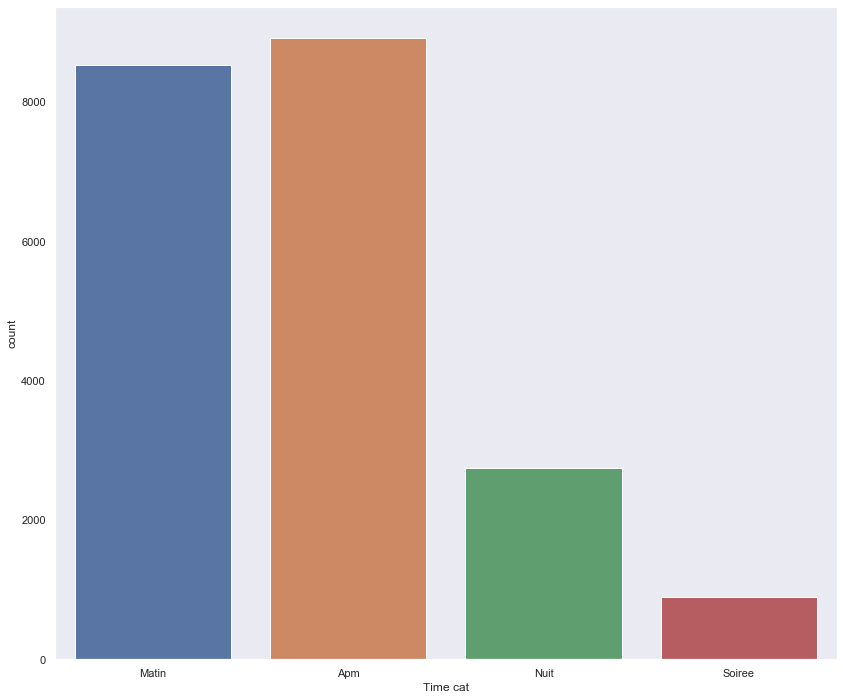

In [25]:
plt.figure(figsize = (14,12))
sns.countplot(x = df_merged['Time cat'])
plt.show()

#### Outliers sur la target

In [26]:
compteur = 0
Q1 = df['Time from Pickup to Arrival'].quantile(0.25)
Q3 = df['Time from Pickup to Arrival'].quantile(0.75)
IQR = Q3 - Q1
for i in range(df['Time from Pickup to Arrival'].shape[0]):
    if(df['Time from Pickup to Arrival'][i] > Q3 + 1.5*IQR):
        compteur+=1
print("Il y'a", str(compteur),"outliers", 
      "soit","{:.2f}".format(compteur/df['Time from Pickup to Arrival'].shape[0]*100) ,'% des données')

Il y'a 775 outliers soit 3.66 % des données


### Relation Variables / Target

#### Relation Target / Variables quantitatives

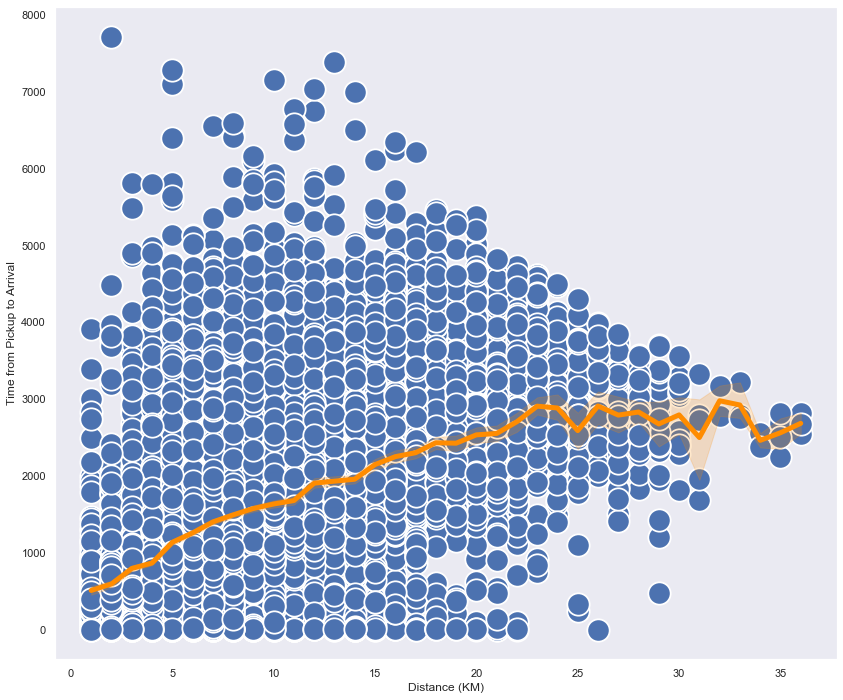

In [27]:
plt.figure(figsize = (14,12))
sns.scatterplot(data=df_merged, x='Distance (KM)', y="Time from Pickup to Arrival", s = 500)
sns.lineplot(data=df_merged, x='Distance (KM)', y="Time from Pickup to Arrival", color = 'darkorange', 
            linewidth = 5)

In [28]:
from sklearn.feature_selection import mutual_info_regression
mi = mutual_info_regression(df_merged[numerical_col].dropna(axis = 1),
                            df_merged['Time from Pickup to Arrival'],
                            discrete_features=False)

In [29]:
col = df_merged[numerical_col].dropna(axis = 1).columns.tolist()

In [30]:
for i in range(len(col)):
    print('MI', col[i],':', mi[i])

MI Placement - Day of Month : 0.0032884078280570606
MI Confirmation - Day of Month : 0.00318340543754303
MI Arrival at Pickup - Day of Month : 0.00287880950603725
MI Pickup - Day of Month : 0.0026782938629477115
MI Arrival at Destination - Day of Month : 0.0032267889349739676
MI Distance (KM) : 0.3539738318390553
MI Pickup Lat : 0.08674847366692173
MI Pickup Long : 0.08676832666108236
MI Destination Lat : 0.09678816347381503
MI Destination Long : 0.089373833273382
MI No_Of_Orders : 0.059424521717056145
MI Age : 0.050404598959215896
MI Average_Rating : 0.030535712642511204
MI No_of_Ratings : 0.04859653593578095
MI Speed km/h : 3.5559743097856904


Seule Distance semble avoir une vraie corrélation avec la target.

#### Relation Target / Variables quantatives

Sur les jours de la semaine, on observe un léger impact sur la target quand le jour est un jour de weekend. Mis à part cela, on n'observe pas de différence ou d'impact significatif sur la target (peut être platform type).

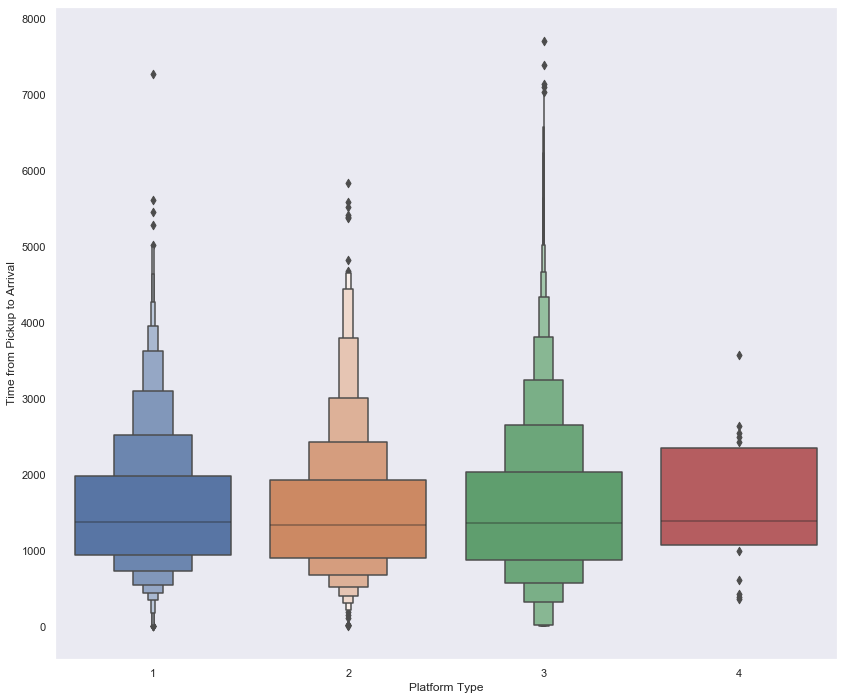

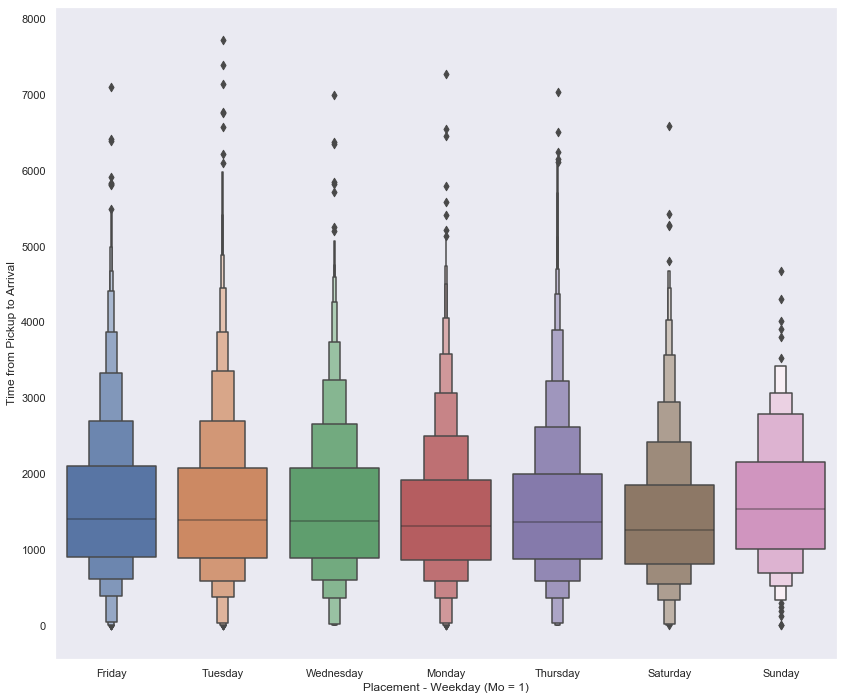

In [31]:
for col in  ['Platform Type', 'Placement - Weekday (Mo = 1)']:
    plt.figure(figsize = (14,12))
    h = sns.boxenplot(data = df_merged, x = col, y='Time from Pickup to Arrival')
    plt.xlabel(col)
    plt.ylabel('Time from Pickup to Arrival')
    plt.show()

In [32]:
listwe = list()
for i in df_merged['Placement - Weekday (Mo = 1)']:
    if i == 'Saturday' or i == 'Sunday':
        listwe.append(True)
    else:
        listwe.append(False)    

In [33]:
df_merged['Weekend'] = listwe

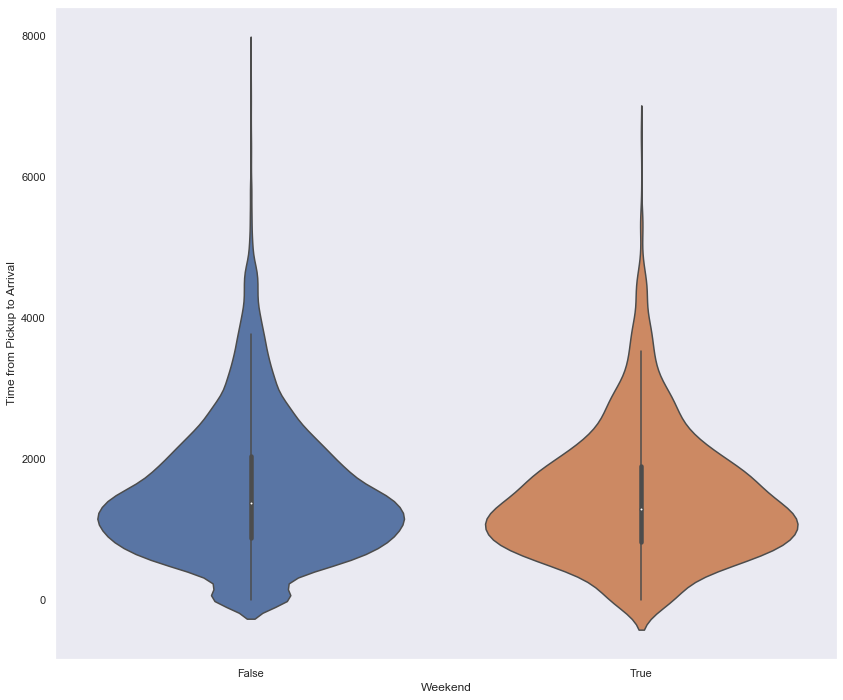

In [34]:
plt.figure(figsize = (14,12))
h = sns.violinplot(data = df_merged, x = 'Weekend', y='Time from Pickup to Arrival')
plt.xlabel('Weekend')
plt.ylabel('Time from Pickup to Arrival')
plt.show()

Il y'a en effet une différence assez légère.

#### Relation Target / Variables de temps

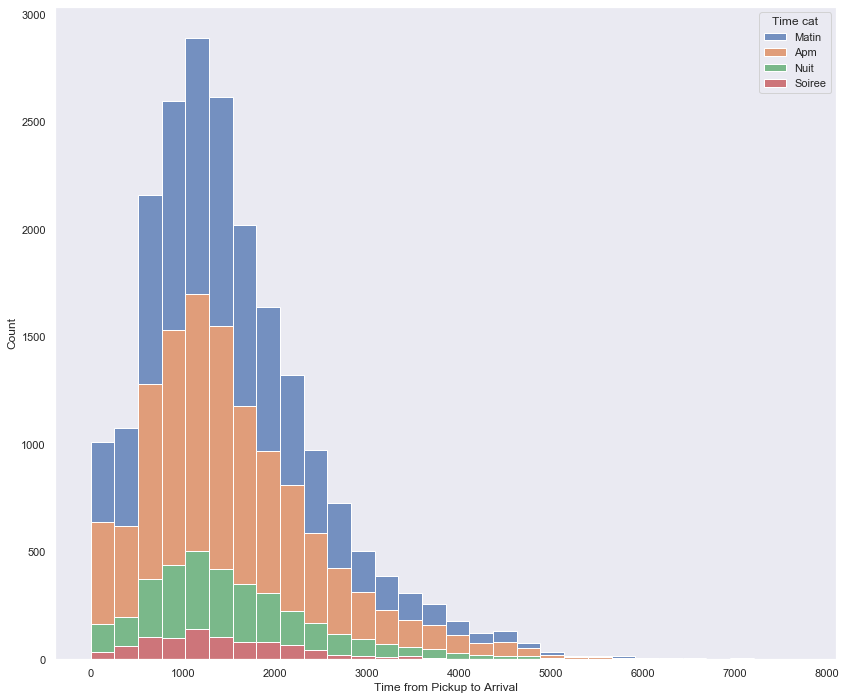

In [35]:
plt.figure(figsize = (14,12))
sns.histplot(data=df_merged, x="Time from Pickup to Arrival",bins = 30, hue = 'Time cat', multiple="stack")
plt.show()

Les variables de temps ne semblent pas avoir un impact significatif sur la target.

### Relation Variables / Variables

#### Variables quantitatives / quantitatives

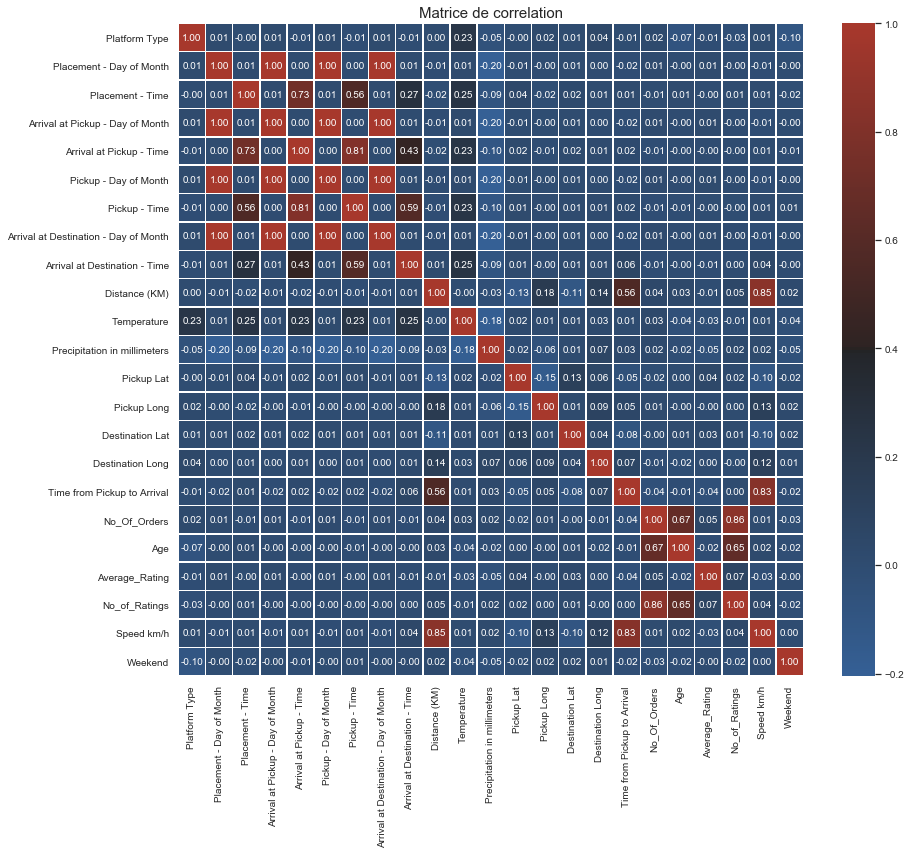

In [36]:
plt.figure(figsize=(14,12))
ax = sns.heatmap(df_merged.drop(['Confirmation - Day of Month', 'Confirmation - Time', ],axis = 1).corr(method='pearson'), 
                linewidths=.5,
                annot=True,
                annot_kws={"size": 10},
                fmt=".2f",
                cmap = sns.diverging_palette(250, 15, s=75, l=40, n=9, center="dark", as_cmap = True))
plt.title('Matrice de correlation', fontsize = 15)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.show()

Cette matrice de corrélation nous indique plusieurs choses :
<ul>
    <li>Contrairement aux variables "Day of Month", les variables "Time" ne sont pas exactements identiques </li>
    <li>Le type de plateforme utilisé est faiblement corrélé (0.2) à la température</li>
    <li>La température est également faiblement corrélée aux variables "Time"</li>
    <li>Le niveau de précipitation est faiblement corrélé aux variables "Day of Month"</li>
    <li>La distance est fortement corrélée au temps de livraison (la target)</li>
    <li>L'age du livreur et son nombre de commandes réalisé sont fortements corrélés</li>
    <li>Le nombre de commandes réalisés et le nombre de notes est fortement corrélé</li>
</ul>

#### Variables qualitatives / qualitatives

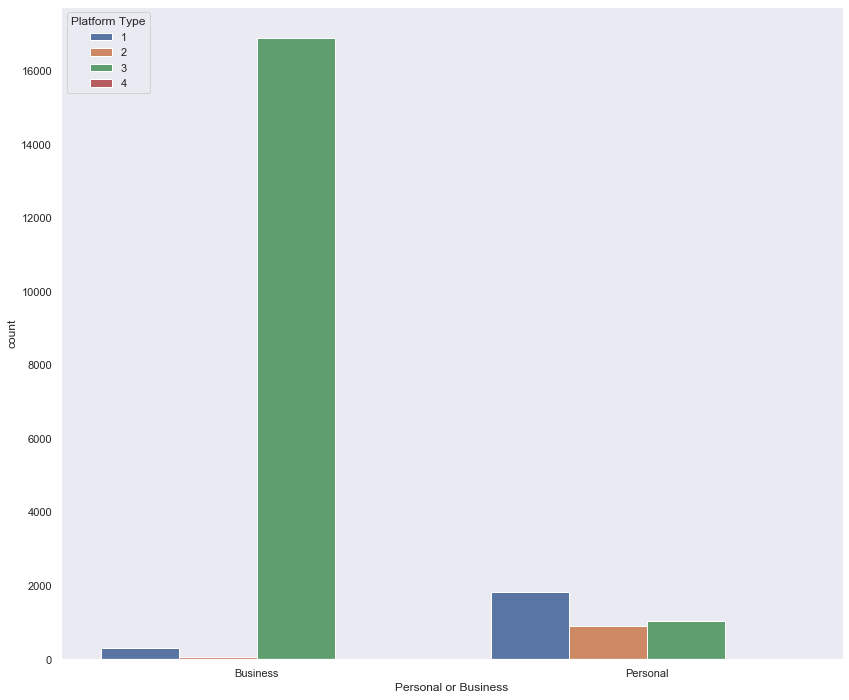

In [37]:
plt.figure(figsize = (14,12))
sns.countplot(x = df_merged['Personal or Business'], hue = df_merged['Platform Type'])
plt.show()

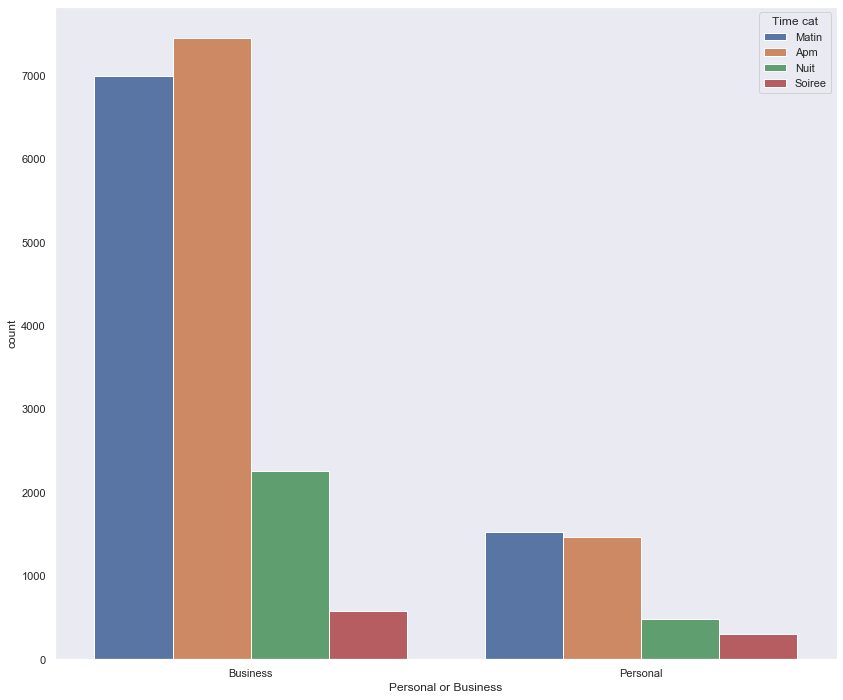

In [38]:
plt.figure(figsize = (14,12))
sns.countplot(x = df_merged['Personal or Business'], hue = df_merged['Time cat'])
plt.show()

<ul>
    <li> Les clients Buisness commandent majoritairement sur la plateforme 3 </li>
    <li> Gap plus important pour les buisness que personal entre journée et soirée. </li>
</ul>

#### Variables quantitatives / qualitatives

<Figure size 1008x864 with 0 Axes>

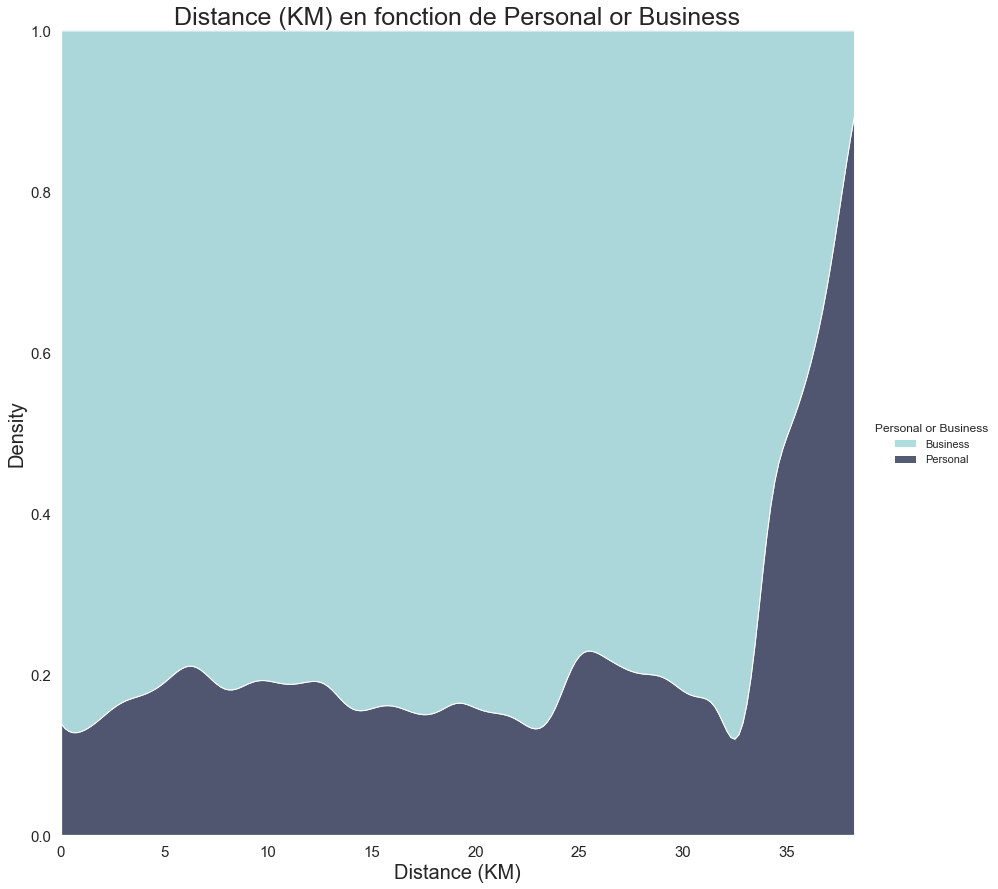

<Figure size 1008x864 with 0 Axes>

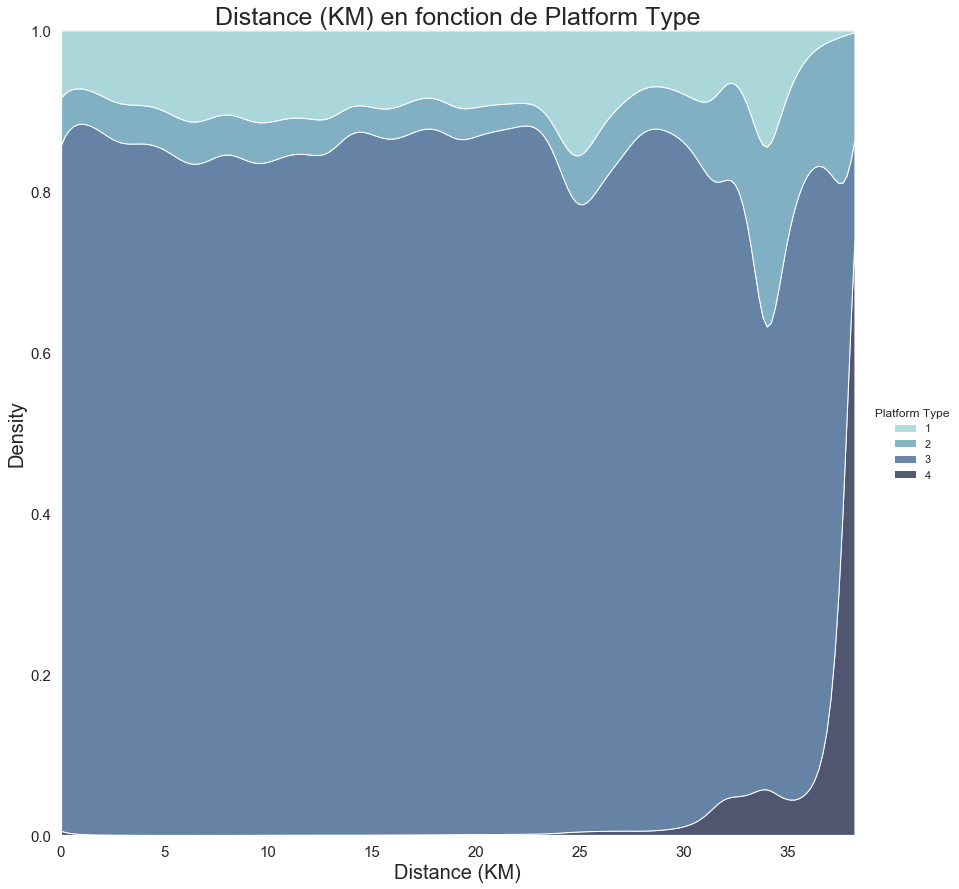

<Figure size 1008x864 with 0 Axes>

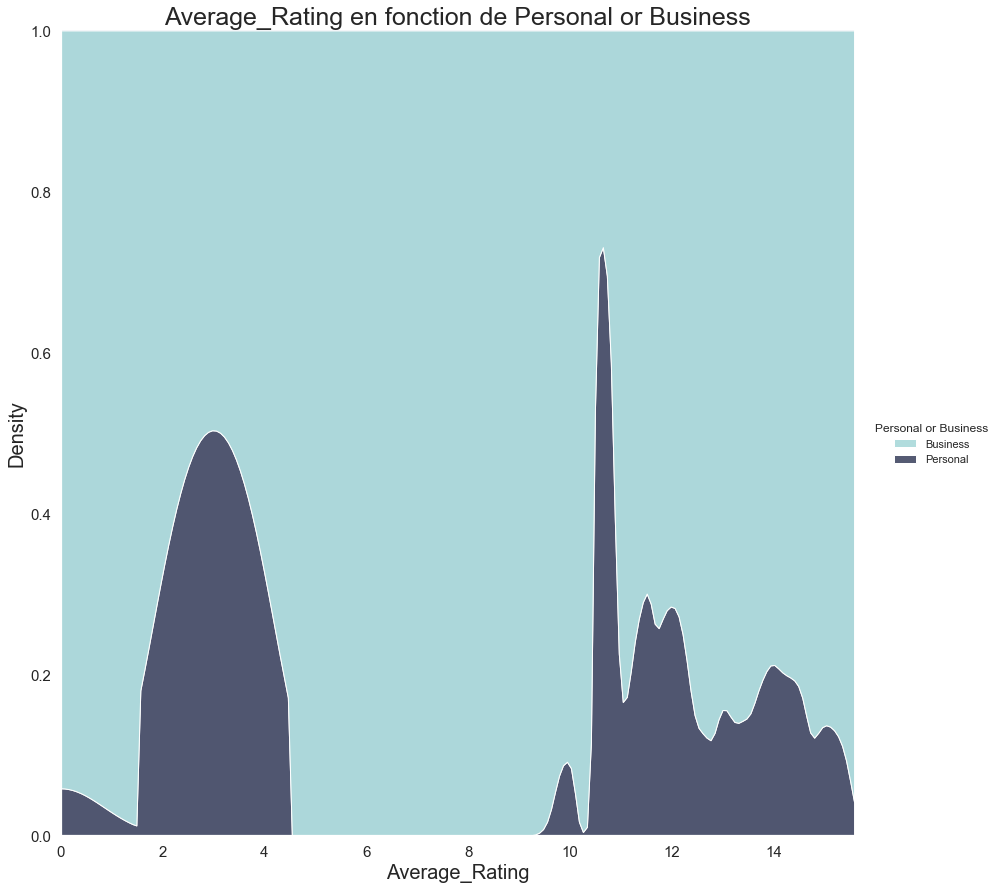

<Figure size 1008x864 with 0 Axes>

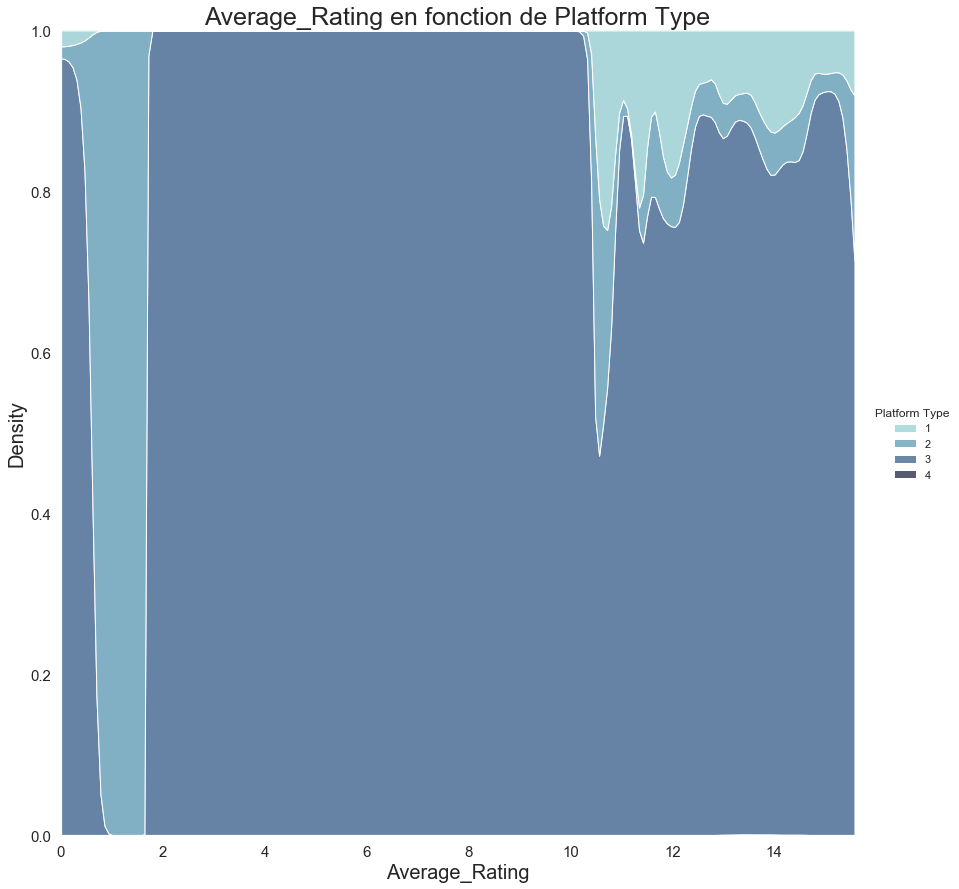

In [39]:
xlist = ['Distance (KM)', 'Average_Rating']
huelist = ['Personal or Business', 'Platform Type']
for variable in xlist:
    for elem in huelist:
        plt.figure(figsize = (14,12))
        sns.displot(
        data=df_merged,
            x=variable, hue=df_merged[elem],
            kind="kde", height=12,
            multiple="fill", clip=(0, None),
            palette="ch:rot=-.25, hue=1, light=.75")
        plt.title(str(variable)+' en fonction de '+str(elem), fontsize = 25)
        plt.xlabel(variable, fontsize = 20)
        plt.ylabel('Density', fontsize = 20)
        plt.xticks(fontsize = 15)
        plt.yticks(fontsize = 15)
        plt.show()

<ul>
    <li> Les trajets pour les clients "Personal" ne dépassent pas les 40 km contrairement aux "Buisness" </li>
    <li> Grande majorité des commandes se font sur la plateforme 3, mais grand nombre de commandes à 45 km environ se font sur la plateforme 1 </li>
    <li> Les particuliers semblent noté ou mal ou bien, il n'y pas d'entre deux. Ou la densité écrasé face au nombre de Buisness</li>
    <li> Les commandes issues de la platform 2 semblent très mal notées </li>
    <li> (non affiché) : Les particuliers semblent commander beaucoup quand il fait froid </li>
</ul>

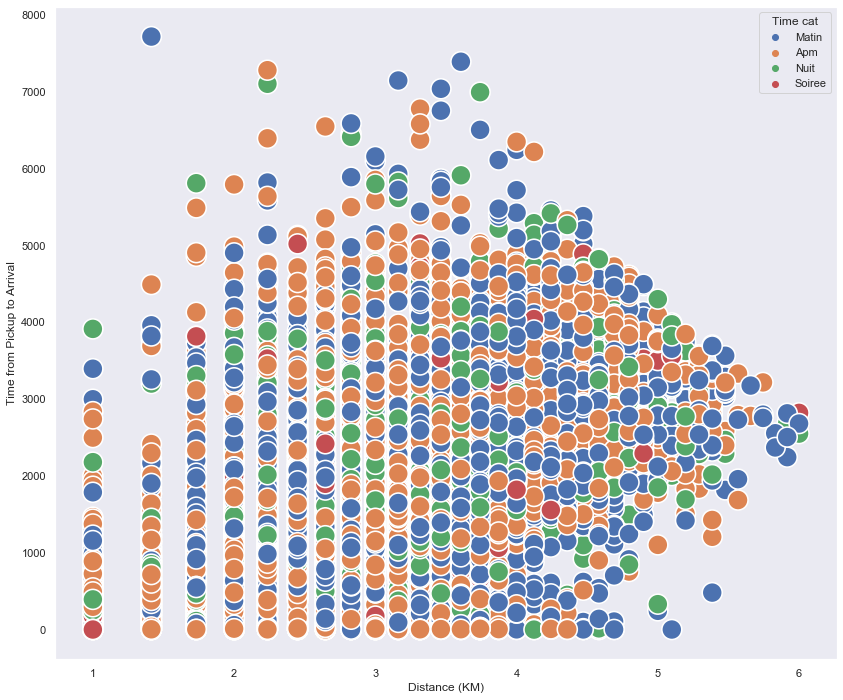

In [40]:
plt.figure(figsize = (14, 12))
sns.scatterplot(data=df_merged, x=np.sqrt(df_merged['Distance (KM)']), y="Time from Pickup to Arrival", s = 400, hue = "Time cat")
plt.show()

In [41]:
def transfo_age(x):
    if (x < 1500):
        return 'GA 1'
    elif (x >= 1500 and x < 2500):
        return 'GA 2'
    else:
        return 'GA 3'

In [42]:
df_merged['Age cat'] = df_merged['Age'].apply(transfo_age)

In [43]:
print(df_merged[['Distance (KM)', 'Time from Pickup to Arrival']].corr(method = 'pearson'))
print('----------------------------------------------------------------------------------------------------------------')
for elem in df_merged['Age cat'].unique():
    print(elem)
    print(df_merged[df_merged['Age cat'] == elem][['Distance (KM)', 'Time from Pickup to Arrival']].corr(method = 'pearson'))
    print('----------------------------------------------------------------------------------------------------------------')

                             Distance (KM)  Time from Pickup to Arrival
Distance (KM)                     1.000000                     0.559992
Time from Pickup to Arrival       0.559992                     1.000000
----------------------------------------------------------------------------------------------------------------
GA 1
                             Distance (KM)  Time from Pickup to Arrival
Distance (KM)                      1.00000                      0.56756
Time from Pickup to Arrival        0.56756                      1.00000
----------------------------------------------------------------------------------------------------------------
GA 2
                             Distance (KM)  Time from Pickup to Arrival
Distance (KM)                     1.000000                     0.533786
Time from Pickup to Arrival       0.533786                     1.000000
----------------------------------------------------------------------------------------------------------------
GA 

En séparant Distance (KM) en fonction des catégories d'âge on a :
<ul>
    <li> Le coefficient de corrélation pour les catégories d'âge 1 et 3 est légèrement au dessus que sans le filtre </li>
    <li> Le ccor pour la catégorie d'âge 2 est en dessous </li>
    </ul>

In [44]:
print(df_merged[['Distance (KM)', 'Time from Pickup to Arrival']].corr(method = 'pearson'))
print('----------------------------------------------------------------------------------------------------------------')
for elem in df_merged['Time cat'].unique():
    print(elem)
    print(df_merged[df_merged['Time cat'] == elem][['Distance (KM)', 'Time from Pickup to Arrival']].corr(method = 'pearson'))
    print('----------------------------------------------------------------------------------------------------------------')

                             Distance (KM)  Time from Pickup to Arrival
Distance (KM)                     1.000000                     0.559992
Time from Pickup to Arrival       0.559992                     1.000000
----------------------------------------------------------------------------------------------------------------
Matin
                             Distance (KM)  Time from Pickup to Arrival
Distance (KM)                     1.000000                     0.553544
Time from Pickup to Arrival       0.553544                     1.000000
----------------------------------------------------------------------------------------------------------------
Apm
                             Distance (KM)  Time from Pickup to Arrival
Distance (KM)                     1.000000                     0.558182
Time from Pickup to Arrival       0.558182                     1.000000
----------------------------------------------------------------------------------------------------------------
Nui

Le ccor sur la soirée est de 0,1 supérieur au ccor sans le filtre sur le temps. On peut créer une variable booleene pour exploiter ce résultat

In [45]:
df_merged['Est Soiree'] = df_merged['Time cat'] == 'Soiree'

In [46]:
categorical_col.append('Est Soiree')

In [47]:
def analyse_corr(col, filtre):
    print(df_merged[[col, 'Time from Pickup to Arrival']].corr(method = 'pearson'))
    print('----------------------------------------------------------------------------------------------------------------')
    for elem in df_merged[filtre].unique():
        print(elem)
        print(df_merged[df_merged[filtre] == elem][[col, 'Time from Pickup to Arrival']].corr(method = 'pearson'))
        print('----------------------------------------------------------------------------------------------------------------')

In [48]:
categorical_col = ['Est Soiree', 'Weekend', 'Platform Type', 'Personal or Business', 'Vehicle Type']

In [49]:
for elem in numerical_col:
    if (np.abs(df_merged[[elem, 'Time from Pickup to Arrival']].corr(method = 'pearson').iloc[0, 1]) > 0.1):
        for filtre in categorical_col:
            print(filtre)
            analyse_corr(elem, filtre)

Est Soiree
                             Distance (KM)  Time from Pickup to Arrival
Distance (KM)                     1.000000                     0.559992
Time from Pickup to Arrival       0.559992                     1.000000
----------------------------------------------------------------------------------------------------------------
False
                             Distance (KM)  Time from Pickup to Arrival
Distance (KM)                     1.000000                     0.556202
Time from Pickup to Arrival       0.556202                     1.000000
----------------------------------------------------------------------------------------------------------------
True
                             Distance (KM)  Time from Pickup to Arrival
Distance (KM)                     1.000000                     0.657306
Time from Pickup to Arrival       0.657306                     1.000000
--------------------------------------------------------------------------------------------------------

<ul>
    <li>Distance est la seule variable corrélée au delà des 0,1 donc vraiment utile pour l'analyse. Son ccor sans filtre est de 0,55 </li>
    <li>Speed fortement corrélée mais inutilisable car calculable uniquement si la target est connue</li>
    <li><b>Pour la variable Distance (KM) :</b></li>
    <li>Le fait d'être en soirée augmente la correlation de 10% (pearson ccor = 0,65)</li>
    <li>Le fait d'être en en weekend augmente la correlation (pearson ccor = 0,62)</li>
    <li>En filtrant par plateforme de livraison, on observe des ccor de 0,6 et 0,61 pour les plateformes 2 et 4</li>
    <li>Suggestion : On peut créer une variable vitesse prédite issue d'un premier modèle, qu'on utilserait pour prédire la vitesse réelle.</li>
    <li>Note : Le fait de supprimer les valeurs aberrantes sur la target réduit la corrélation de distance à la target</li>
</ul>

On peut s'interroger sur la vitesse, qui semble très faible pour des cyclistes. En effet est-ce réaliste qu'un coursier avec une contrainte de temps roule à moins de 5 km/h en vélo ? 

In [50]:
df_merged['Speed km/h'].describe()

count    21080.000000
mean         4.832089
std          5.046260
min          0.000278
25%          1.297153
50%          3.107500
75%          6.623750
max         29.960000
Name: Speed km/h, dtype: float64

On fait l'hypothèse que certains sont en fait des piétons, et on définit un seuil minimum pour lequel le livreur est considéré comme piéton

In [54]:
def deplacement_type(s_threshold):
    list_return = list()
    for i in range(df_merged['Speed km/h'].shape[0]):
        if(df_merged['Speed km/h'].iloc[i] < s_threshold):
            list_return.append('Walker')
        else:
            list_return.append('Bike')
    return(list_return)

On fait varier le seuil de vitesse entre 1 et 30 et l'on enregistre les différentes corrélations obtenues par rapport à distance

In [88]:
walker_ccor = list()
bike_ccor = list()
walker_cumul = list()
bike_cumul = list()

for i in range(30):
    df_merged['Vehicle Type'] = deplacement_type(i)
    for elem in df_merged['Vehicle Type'].unique():
        if (elem == 'Walker'):
            walker_cumul.append((df_merged['Vehicle Type'] == elem).sum())
            walker_ccor.append(np.abs(df_merged[df_merged['Vehicle Type'] == elem][['Distance (KM)', 'Time from Pickup to Arrival']].corr(method = 'pearson').iloc[0, 1]))
        else:
            bike_cumul.append((df_merged['Vehicle Type'] == elem).sum())
            bike_ccor.append(np.abs(df_merged[df_merged['Vehicle Type'] == elem][['Distance (KM)', 'Time from Pickup to Arrival']].corr(method = 'pearson').iloc[0, 1]))

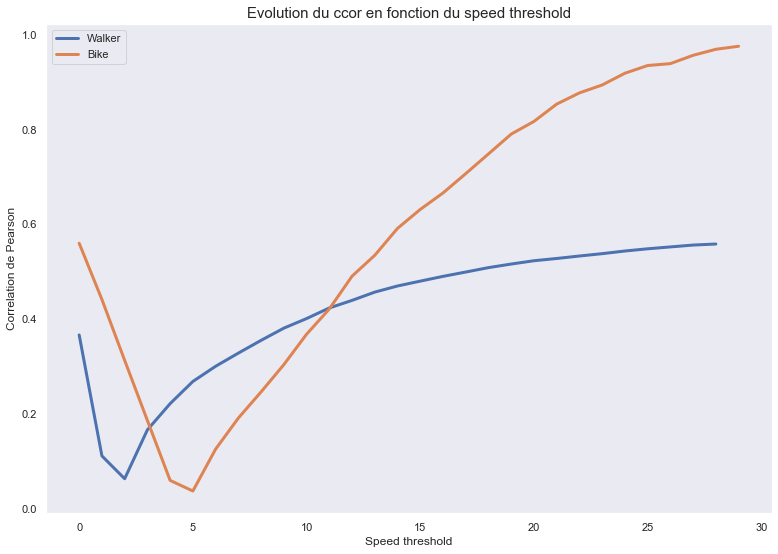

In [94]:
plt.figure(figsize = (13,9))
plt.plot(walker_ccor, label = 'Walker', linewidth = 3)
plt.plot(bike_ccor, label = 'Bike', linewidth = 3)
plt.xlabel('Speed threshold', fontsize = 12)
plt.ylabel('Correlation de Pearson', fontsize = 12)
plt.title('Evolution du ccor en fonction du speed threshold', fontsize = 15)
plt.legend()
plt.show()

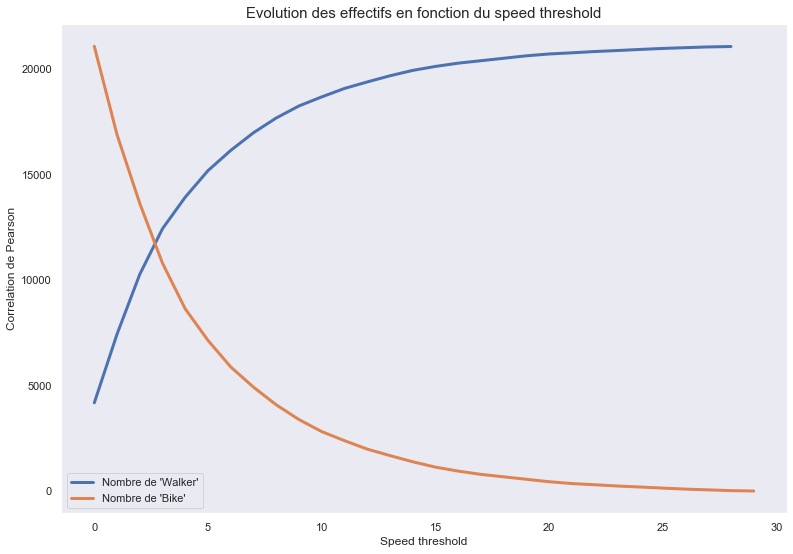

In [106]:
plt.figure(figsize = (13,9))
plt.plot(walker_cumul, label = 'Nombre de \'Walker\'',  linewidth = 3)
plt.plot(bike_cumul, label = 'Nombre de \'Bike\'', linewidth = 3)
plt.xlabel('Speed threshold', fontsize = 12)
plt.ylabel('Correlation de Pearson', fontsize = 12)
plt.title('Evolution des effectifs en fonction du speed threshold', fontsize = 15)
plt.legend()
plt.show()

Plus on augmente le seuil, plus la corrélation en fonction du moyen de locomotion augmente, toutefois cela réduit l'effectif de la catégorie 'Bike' qui tend vers 0.

In [107]:
df_merged ['Vehicle Type'] = deplacement_type(20)
print(bike_cumul[20])
analyse_corr('Distance (KM)', 'Vehicle Type')

453
                             Distance (KM)  Time from Pickup to Arrival
Distance (KM)                     1.000000                     0.559992
Time from Pickup to Arrival       0.559992                     1.000000
----------------------------------------------------------------------------------------------------------------
Walker
                             Distance (KM)  Time from Pickup to Arrival
Distance (KM)                     1.000000                     0.515978
Time from Pickup to Arrival       0.515978                     1.000000
----------------------------------------------------------------------------------------------------------------
Bike
                             Distance (KM)  Time from Pickup to Arrival
Distance (KM)                     1.000000                    -0.817185
Time from Pickup to Arrival      -0.817185                     1.000000
--------------------------------------------------------------------------------------------------------------

On peut se fixer un seuil à 20 km/h pour garder un certain effectif et obtenir une corrélation satisfaisante. Etant donné la forte corrélation entre le fait d'être à vélo et la target, on pourrait créer un modèle de classification permettant de déterminer si le livreur est en vélo ou à pied.